In this project, I will use machine learning models to predict Major-League Baseball team wins per season based on Lahman's Baseball data.

Agenda:
* importing the data
* cleaning and preparing the data
* exploring and visualizing the data
* adding new features
* adding one more feature using K-means clustering
* splitting dataset into train_set and test_set
* selecting error metric: mean absolute error vs mean squared error
* linear regression model
* ridge regression model
* conclusion

**Importing data**

In [2]:
import sqlite3
import pandas as pd

connect to sqlite database


In [3]:
conn = sqlite3.connect('lahman2016.sqlite')

filter data to only include teams that are currently active and paly 150 or more games

In [4]:
query = '''select * from Teams
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == 'Y';
'''

get results from database

In [5]:
Teams = conn.execute(query).fetchall()

convert 'Teams' to a dataframe using pandas library

In [6]:
teams_df = pd.DataFrame(Teams)
teams_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1961,AL,LAA,ANA,None,8,162,82.0,70,91,...,603510,111,112,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
1,1962,AL,LAA,ANA,None,3,162,81.0,86,76,...,1144063,97,97,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
2,1963,AL,LAA,ANA,None,9,161,81.0,70,91,...,821015,94,94,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
3,1964,AL,LAA,ANA,None,5,162,81.0,82,80,...,760439,90,90,LAA,LAA,LAA,ANA,Los Angeles Angels of Anaheim,Y,None
4,1965,AL,CAL,ANA,None,7,162,80.0,75,87,...,566727,97,98,CAL,CAL,CAL,ANA,Los Angeles Angels of Anaheim,Y,None


**Cleaning and preparing the data**

add column names to dataframe

In [7]:
cols = ['yearID','lgID','teamID','franchID','divID',
        'Rank','G','Ghome','W','L','DivWin','WCWin',
        'LgWin','WSWin','R','AB','H','2B','3B','HR',
        'BB','SO','SB','CS','HBP','SF','RA','ER','ERA',
        'CG','SHO','SV','IPouts','HA','HRA','BBA','SOA',
        'E','DP','FP','name','park','attendance','BPF',
        'PPF','teamIDBR','teamIDlahman45','teamIDretro',
        'franchID','franchName','active','NAassoc']
teams_df.columns = cols

In [10]:
print(teams_df.head(2))

   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L   ...     \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91   ...      
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76   ...      

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro  franchID  \
0     603510  111  112      LAA             LAA          LAA       ANA   
1    1144063   97   97      LAA             LAA          LAA       ANA   

                      franchName  active  NAassoc  
0  Los Angeles Angels of Anaheim       Y     None  
1  Los Angeles Angels of Anaheim       Y     None  

[2 rows x 52 columns]


In [11]:
len(teams_df)

2287

drop unnecessary column variables

In [12]:
drop_cols = ['lgID','franchID','divID','Rank','Ghome',
             'L','DivWin','WCWin','LgWin','WSWin','SF',
             'name','park','attendance','BPF','PPF',
             'teamIDBR','teamIDlahman45','teamIDretro',
             'franchID','franchName','active','NAassoc']
df = teams_df.drop(drop_cols,axis=1)

In [13]:
df.head(2)

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,5,34,4314,1391,180,713,973,192,154.0,0.969
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,15,47,4398,1412,118,616,858,175,153.0,0.972


check how many null values for each column

In [18]:
print(df.isnull().sum(axis=0).tolist())
#axis=0: act on all rows for each column
#axis=1: act on all columns for each row

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 419, 1777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


It shows that we have 110 null values in the 'SO'(strike outs) column, 22 in the 'DP'(double play) column, 419 in the 'CS'(caught stealing) column and 1777 in the 'HBP'(hit by pitch) column.

Since columns 'SO' and 'DP' are important for predicting the wins, I will fill the null values in them by median. In addition, I will drop 'CS' and 'HBP' because they are not important for the target.

In [19]:
df = df.drop(['CS','HBP'],axis=1)

In [20]:
df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

In [21]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Exploring and visualizing the data**

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

visualize the histogram of wins

Text(0.5,1,'histogram of wins')

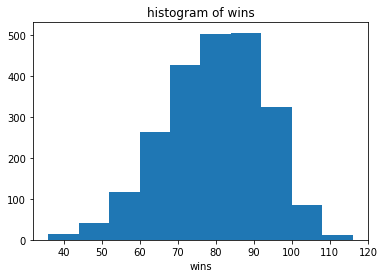

In [23]:
plt.hist(df['W'])
plt.xlabel('wins')
plt.title('histogram of wins')

check out the average wins

In [24]:
df['W'].mean()

79.23043288150416

create win labels column for classification

In [27]:
#create bins for each win values
def assign_win_bins(w):
    if w < 50:
        return 1
    if w >= 50 and w <= 69:
        return 2
    if w >= 70 and w <= 89:
        return 3
    if w >= 90 and w <= 109:
        return 4
    if w >= 110:
        return 5

In [28]:
#apply to the 'W' column
df['win_bins'] = df['W'].apply(assign_win_bins)

visualize wins per year colored with win_bins

Text(0,0.5,'wins')

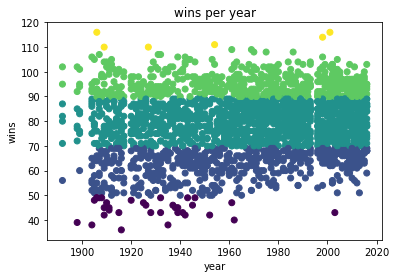

In [30]:
plt.scatter(df['yearID'],df['W'],c=df['win_bins'])
plt.title('wins per year')
plt.xlabel('year')
plt.ylabel('wins')

it seems we have much less data before 1900 than after, so it makes sense to drop them.

In [31]:
df = df[df['yearID']>1900]

integer values like yearID may cause problems. It is unlikely that year 1950 will have the same relationship to the rest of the data 

Thus, I will create new variables that label the data based on yearID

start by creating dictionaries runs_per_year and games_per_year

In [32]:
runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games

In [33]:
print(runs_per_year)

{1961: 12942, 1962: 14461, 1963: 12780, 1964: 13124, 1965: 12946, 1966: 12900, 1967: 12210, 1968: 11109, 1969: 15850, 1970: 16880, 1971: 15073, 1972: 13706, 1973: 16376, 1974: 16046, 1975: 16295, 1976: 15492, 1977: 18803, 1978: 17251, 1979: 18713, 1980: 18053, 1982: 18110, 1983: 18170, 1984: 17921, 1985: 18216, 1986: 18545, 1987: 19883, 1988: 17380, 1989: 17405, 1990: 17919, 1991: 18127, 1992: 17341, 1993: 20864, 1996: 22831, 1997: 21604, 1998: 23297, 1999: 24691, 2000: 24971, 2001: 23199, 2002: 22408, 2003: 22978, 2004: 23376, 2005: 22325, 2006: 23599, 2007: 23322, 2008: 22585, 2009: 22419, 2010: 21308, 2011: 20808, 2012: 21017, 2013: 20255, 2014: 19761, 2015: 20647, 2016: 21744, 1904: 9307, 1905: 9640, 1906: 8322, 1907: 8186, 1908: 8423, 1909: 8805, 1910: 9580, 1911: 11164, 1912: 11154, 1913: 9964, 1914: 9408, 1915: 9444, 1916: 8889, 1917: 8948, 1920: 10762, 1921: 11935, 1922: 12059, 1923: 11874, 1924: 11722, 1925: 12596, 1926: 11443, 1927: 11745, 1928: 11645, 1929: 12747, 1930: 1369

In [34]:
print(games_per_year)

{1961: 2860, 1962: 3242, 1963: 3238, 1964: 3252, 1965: 3246, 1966: 3230, 1967: 3240, 1968: 3250, 1969: 3892, 1970: 3888, 1971: 3876, 1972: 3718, 1973: 3886, 1974: 3890, 1975: 3868, 1976: 3878, 1977: 4206, 1978: 4204, 1979: 4198, 1980: 4210, 1982: 4214, 1983: 4218, 1984: 4210, 1985: 4206, 1986: 4206, 1987: 4210, 1988: 4200, 1989: 4212, 1990: 4210, 1991: 4208, 1992: 4212, 1993: 4538, 1996: 4534, 1997: 4532, 1998: 4864, 1999: 4856, 2000: 4858, 2001: 4858, 2002: 4852, 2003: 4860, 2004: 4856, 2005: 4862, 2006: 4858, 2007: 4862, 2008: 4856, 2009: 4860, 2010: 4860, 2011: 4858, 2012: 4860, 2013: 4862, 2014: 4860, 2015: 4858, 2016: 4856, 1904: 2498, 1905: 2474, 1906: 2307, 1907: 2317, 1908: 2488, 1909: 2482, 1910: 2498, 1911: 2474, 1912: 2464, 1913: 2468, 1914: 2512, 1915: 2490, 1916: 2494, 1917: 2494, 1920: 2468, 1921: 2458, 1922: 2476, 1923: 2466, 1924: 2462, 1925: 2456, 1926: 2468, 1927: 2472, 1928: 2462, 1929: 2458, 1930: 2468, 1931: 2472, 1932: 2466, 1933: 2303, 1934: 2297, 1935: 2158, 193

create mlb_runs_per_game dictionary with years as keys and number of runs per game as value

In [38]:
mlb_runs_per_game = {}

for k,v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs/games

In [39]:
print(mlb_runs_per_game)

{1961: 4.525174825174825, 1962: 4.460518198642813, 1963: 3.9468807906114884, 1964: 4.035670356703567, 1965: 3.9882932840418976, 1966: 3.9938080495356036, 1967: 3.7685185185185186, 1968: 3.4181538461538463, 1969: 4.07245632065776, 1970: 4.341563786008231, 1971: 3.8888028895768834, 1972: 3.6863905325443787, 1973: 4.214101904271745, 1974: 4.124935732647815, 1975: 4.21277145811789, 1976: 3.99484270242393, 1977: 4.470518307180218, 1978: 4.103472882968601, 1979: 4.457598856598381, 1980: 4.2881235154394295, 1982: 4.297579496915045, 1983: 4.307728781412992, 1984: 4.256769596199525, 1985: 4.330955777460771, 1986: 4.409177365668093, 1987: 4.722802850356294, 1988: 4.1380952380952385, 1989: 4.132241215574549, 1990: 4.256294536817102, 1991: 4.307747148288973, 1992: 4.1170465337132, 1993: 4.597620096959012, 1996: 5.0355094838994265, 1997: 4.766990291262136, 1998: 4.789679276315789, 1999: 5.0846375617792425, 2000: 5.140181144503911, 2001: 4.7754219843557015, 2002: 4.6183017312448476, 2003: 4.72798353

visualize yearly MLB runs per game

In [44]:
#create lists from mlb_runs_per_game dictionary
lists = sorted(mlb_runs_per_game.items())
x,y = zip(*lists)
#x is the list of keys, y is the list of values

Text(0,0.5,'mlb runs per game')

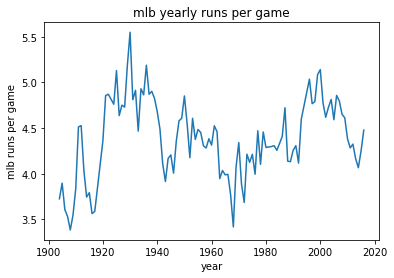

In [46]:
#create line plot of mlb_runs_per_game vs year
plt.plot(x,y)
plt.title('mlb yearly runs per game')
plt.xlabel('year')
plt.ylabel('mlb runs per game')

**Adding new features**

Based on the trend of mlb runs, we can create a new variable 'year_label' that indicate era. 

In [49]:
def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8

In [50]:
df['year_label'] = df['yearID'].apply(assign_label)

create dummy variables for 'year_label'

In [51]:
dummy_df = pd.get_dummies(df['year_label'],prefix='era')

In [52]:
dummy_df.head()

,era_1,era_2,era_3,era_4,era_5,era_6,era_7,era_8
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [54]:
df = pd.concat([df,dummy_df],axis=1)

In [55]:
df.head(2)

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,...,win_bins,year_label,era_1,era_2,era_3,era_4,era_5,era_6,era_7,era_8
0,1961,LAA,162,70,744,5424,1331,218,22,189,...,3,4,0,0,0,1,0,0,0,0
1,1962,LAA,162,86,718,5499,1377,232,35,137,...,3,4,0,0,0,1,0,0,0,0


create column for mlb_runs_per_game

In [56]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]
df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

convert years into decades 

In [57]:
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010

In [58]:
df['decade_label'] = df['yearID'].apply(assign_decade)

In [60]:
decade_df = pd.get_dummies(df['decade_label'],prefix='decade')
decade_df.head()

,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [61]:
df = pd.concat([df,decade_df],axis=1)

drop unnecessary columns

In [62]:
df = df.drop(['yearID','year_label','decade_label'],axis=1)

Add two more features to increase the prediction of the model: runs_per_game and runs_allowed_per_game

In [63]:
df['R_per_game'] = df['R']/df['G']
df['RA_per_game'] = df['RA']/df['G']

check how these two variables relate to our target 'W' column

Text(0.5,0,'runs allowed per game')

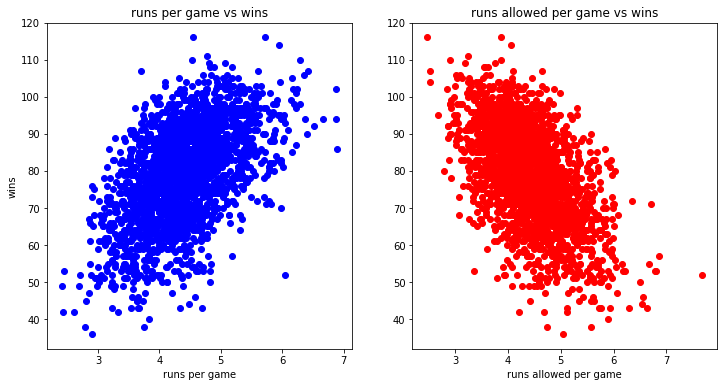

In [65]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'],df['W'],c='blue')
ax1.set_title('runs per game vs wins')
ax1.set_ylabel('wins')
ax1.set_xlabel('runs per game')

ax2.scatter(df['RA_per_game'],df['W'],c='red')
ax2.set_title('runs allowed per game vs wins')
ax2.set_xlabel('runs allowed per game')

visualize correlation between each of the variables and the target variable

In [66]:
df.corr()['W']

G              0.178958
W              1.000000
R              0.551504
AB             0.233996
H              0.380281
2B             0.262323
3B             0.016970
HR             0.312713
BB             0.345348
SO             0.072069
SB             0.133300
RA            -0.518313
ER            -0.372580
ERA           -0.425833
CG            -0.041788
SHO            0.426892
SV             0.382174
IPouts         0.326087
HA            -0.384893
HRA            0.009880
BBA           -0.284782
SOA            0.259205
E             -0.304725
DP             0.015192
FP             0.319597
win_bins       0.912545
era_1         -0.077104
era_2         -0.083089
era_3         -0.033073
era_4         -0.052278
era_5          0.042122
era_6          0.058439
era_7          0.066049
era_8          0.043453
mlb_rpg        0.006909
decade_1910   -0.077104
decade_1920   -0.055176
decade_1930   -0.052358
decade_1940   -0.050249
decade_1950   -0.047499
decade_1960    0.028594
decade_1970    0

**Adding one more feature using K-means clustering**

create the dataframe that leaves out the target column

In [67]:
attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg']


In [68]:
data_attributes = df[attributes]

In [69]:
df.head()

,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,0,1,0,0,0,0,0,4.592593,4.839506
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,0,1,0,0,0,0,0,4.432099,4.358025
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,0,1,0,0,0,0,0,3.708075,4.099379
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,0,1,0,0,0,0,0,3.358025,3.401235
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,0,1,0,0,0,0,0,3.253086,3.512346


using sklearn’s silhouette_score() to select the number of clusters. The best value of this function return is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

I want to have a high silhouette score, the score decreases as more cluster added

In [70]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [72]:
score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters = i, random_state=1)
    l = km.fit_predict(data_attributes)
    score = metrics.silhouette_score(data_attributes,l)
    score_dict[i] = score

In [73]:
score_dict

{2: 0.3906998802293878,
 3: 0.33807585484810926,
 4: 0.2534094006101799,
 5: 0.23561577404187492,
 6: 0.2138869412081822,
 7: 0.19570350588885863,
 8: 0.1866085747852742,
 9: 0.1735454878870926,
 10: 0.16986446409819547}

select 6 as the cluster_size. create K-means model and visualize

In [74]:
kmeans_model = KMeans(n_clusters = 6, random_state=1)

In [78]:
#determine euclidian distances for each data points
distances = kmeans_model.fit_transform(data_attributes)

In [87]:
distances

array([[ 403.64157318,  905.96921371,  418.08948195,  691.28217379,
         881.91035476,  364.27867505],
       [ 176.63291442,  724.86201359,  462.79421258,  528.17076064,
         742.53312859,  356.92059367],
       [ 175.28064133,  760.02048493,  461.22878542,  533.34938643,
         670.03986589,  459.28750389],
       ...,
       [ 645.94940211, 1281.77528634,  315.40745596, 1063.25746178,
        1095.60371693,  628.81413485],
       [ 692.85283233, 1299.34088523,  309.93820869, 1072.79831862,
        1111.7177554 ,  628.41580125],
       [ 738.16587506, 1365.13388024,  349.40577985, 1136.23398531,
        1200.02051407,  665.81041136]])

Text(0.5,1,'kmeans clusters')

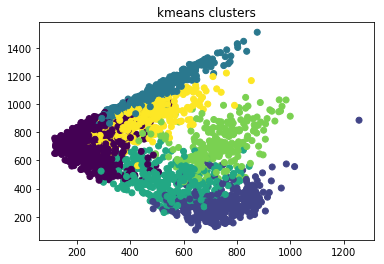

In [81]:
#create scatter plot colored by kmeans clusters
labels = kmeans_model.labels_
plt.scatter(distances[:,0],distances[:,1],c=labels)
plt.title('kmeans clusters')

add labels from the clusters as a new column to the dataset

In [88]:
df['labels'] = labels
attributes.append('labels')
df.head()

,teamID,G,W,R,AB,H,2B,3B,HR,BB,...,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game,labels
0,LAA,162,70,744,5424,1331,218,22,189,681,...,0,1,0,0,0,0,0,4.592593,4.839506,5
1,LAA,162,86,718,5499,1377,232,35,137,602,...,0,1,0,0,0,0,0,4.432099,4.358025,0
2,LAA,161,70,597,5506,1378,208,38,95,448,...,0,1,0,0,0,0,0,3.708075,4.099379,0
3,LAA,162,82,544,5362,1297,186,27,102,472,...,0,1,0,0,0,0,0,3.358025,3.401235,0
4,CAL,162,75,527,5354,1279,200,36,92,443,...,0,1,0,0,0,0,0,3.253086,3.512346,0


**Spliting dataset into train_set and test_set**

create a new dataframe includes only numeric columns 

In [89]:
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3','era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930','decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg','labels','W']


In [90]:
data = df[numeric_cols]

In [91]:
data.head()

,G,R,AB,H,2B,3B,HR,BB,SO,SB,...,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,R_per_game,RA_per_game,mlb_rpg,labels,W
0,162,744,5424,1331,218,22,189,681,1068.0,37,...,0,0,0,0,0,4.592593,4.839506,4.525175,5,70
1,162,718,5499,1377,232,35,137,602,917.0,46,...,0,0,0,0,0,4.432099,4.358025,4.460518,0,86
2,161,597,5506,1378,208,38,95,448,916.0,43,...,0,0,0,0,0,3.708075,4.099379,3.946881,0,70
3,162,544,5362,1297,186,27,102,472,920.0,49,...,0,0,0,0,0,3.358025,3.401235,4.035670,0,82
4,162,527,5354,1279,200,36,92,443,973.0,107,...,0,0,0,0,0,3.253086,3.512346,3.988293,0,75


split data into train and test sets

In [92]:
train = data.sample(frac = 0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

In [93]:
x_train = train[attributes]
y_train = train['W']
x_test = test[attributes]
y_test = test['W']

**Selecting error metric: mean absolute error vs mean squared error**

https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

I will use mean absolute error(MAE) as the error metric. MAE measures the absolute value that my prediction misses the true value.

**Linear regression model**

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

create linear regression model, fit it and make predictions

In [95]:
lr = LinearRegression(normalize=True)

In [96]:
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [97]:
predictions = lr.predict(x_test)

In [98]:
mae = mean_absolute_error(y_test,predictions)

In [99]:
mae

2.688790228995922

Recall that the average number of wins is about 79 wins. On average, the model is off by about 2.687 wins.

**Ridge regression model**

In [100]:
from sklearn.linear_model import RidgeCV

In [101]:
rrm = RidgeCV(alphas=(0.01,0.1,1,10),normalize=True)

In [102]:
rrm.fit(x_train,y_train)

RidgeCV(alphas=(0.01, 0.1, 1, 10), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=False)

In [103]:
predictions = rrm.predict(x_test)

In [104]:
mae_rrm = mean_absolute_error(y_test,predictions)
mae_rrm

2.6725918746465034

Ridge regression model is slightly better than linear regression model because it has less mean absolute error.

**Conclusion**

This is the first part of the 'Baseball Analytics' project. I imported data from SQLite database, cleaned it, explored it to visualize, engineered some new features. Then, I applied K-means clustering model, linear regression model and ridge regression model to predict wins. Finally, I used mean absolute error to evaluate these models. 

I will use classification models to make some other interesting predictions in the second part of the project.